In [1]:
#%%capture
#!pip install transformers

In [2]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [4]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5, cat_count=None):

        super(BertClassifier, self).__init__()        
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, cat_count)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [5]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

In [6]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [7]:
def predict(model, data):
    prediction = []
    test = Dataset(data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            # append to prediction
            #prediction.append(output.argmax(dim=1).cpu().numpy())
            prediction.append(output.argmax(dim=1).cpu().numpy())
    return prediction

In [8]:
#datapath = 'data.csv'
#df = pd.read_csv(datapath)
#print(len(df))
#df.head(3)

In [9]:
#df = pd.read_csv('data.csv', header=None, sep=':')
#df.columns = ['category', 'text']
#print(len(df))
#df.head(3)

In [10]:
# dataset:
# https://cogcomp.seas.upenn.edu/Data/QA/QC/
# Training set 1(1000 labeled questions)
# Load data
with open('data.csv', 'r') as f:
    lines = f.readlines()
    df = pd.DataFrame()
    for line in lines:
        # find first : position in line
        pos = line.find(':')
        # split line by :
        # first element is ENTY
        # second element is DESC
        row = {'category': line[:pos], 'text': line[pos+1:].strip()}
        df = df.append(row, ignore_index=True)

In [11]:
df.head(3)

,category,text
0,DESC,manner How did serfdom develop in and then lea...
1,ENTY,cremat What films featured the character Popey...
2,DESC,manner How can I find a list of celebrities ' ...


<AxesSubplot:xlabel='category'>

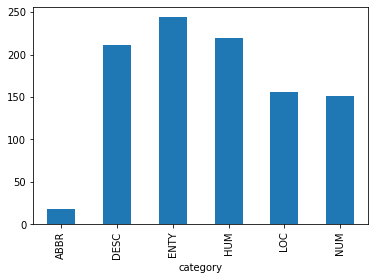

In [12]:
df.groupby(['category']).size().plot.bar()

In [13]:
labels = dict()
categories = [label for label in df.category.unique()]
for i in range(len(categories)):
    labels[categories[i]]=i
labels

{'DESC': 0, 'ENTY': 1, 'ABBR': 2, 'HUM': 3, 'NUM': 4, 'LOC': 5}

In [14]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

800 100 100


In [15]:
EPOCHS = 5
model = BertClassifier(cat_count=len(categories))
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|████████████████████████████████████████████████████████████████████████████| 400/400 [00:55<00:00,  7.18it/s]


Epochs: 1 | Train Loss:  0.911 | Train Accuracy:  0.211 | Val Loss:  0.788 | Val Accuracy:  0.410


100%|████████████████████████████████████████████████████████████████████████████| 400/400 [00:55<00:00,  7.19it/s]


Epochs: 2 | Train Loss:  0.723 | Train Accuracy:  0.489 | Val Loss:  0.575 | Val Accuracy:  0.610


100%|████████████████████████████████████████████████████████████████████████████| 400/400 [00:55<00:00,  7.18it/s]


Epochs: 3 | Train Loss:  0.593 | Train Accuracy:  0.615 | Val Loss:  0.442 | Val Accuracy:  0.740


100%|████████████████████████████████████████████████████████████████████████████| 400/400 [00:56<00:00,  7.11it/s]


Epochs: 4 | Train Loss:  0.469 | Train Accuracy:  0.762 | Val Loss:  0.353 | Val Accuracy:  0.810


100%|████████████████████████████████████████████████████████████████████████████| 400/400 [00:56<00:00,  7.02it/s]


Epochs: 5 | Train Loss:  0.339 | Train Accuracy:  0.877 | Val Loss:  0.246 | Val Accuracy:  0.940


In [16]:
evaluate(model, df_test)

Test Accuracy:  0.920


In [17]:
# save model
torch.save(model.state_dict(), 'model.pt')

In [18]:
# load model
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [19]:
check = df.iloc()[6:9]
result = predict(model,check)
result

[array([3, 3]), array([0])]

In [20]:
j = 0
for i in range(len(result)):
    for r in result[i]:
        print(check.iloc()[j].text, '#', categories[r])
        j+=1

gr What team did baseball 's St. Louis Browns become ? # HUM
title What is the oldest profession ? # HUM
def What are liver enzymes ? # DESC


In [21]:
check

,category,text
6,HUM,gr What team did baseball 's St. Louis Browns ...
7,HUM,title What is the oldest profession ?
8,DESC,def What are liver enzymes ?
